Moving beyond the [simplest model](../02_baseline/baseline_classifier.ipynb), the next step is a deep neural network. Just kidding, the next step is something slightly more complex but still very simple. OneR [@Holte1993] is such a model. Last time we trained a baseline model, now we aim to beat it.

In [1]:
# | echo: false
from nlpbook import get_results

get_results(["Baseline"])

,Accuracy
Model,
Baseline,0.501119


[For reference, here's a table showing the accuracy we achieved last chapter.]{.aside}

## The OneR algorithm

OneR, short for One Rule, works on the sampe principle as the baseline model, but instead of returning the most frequent label in the whole dataset it returns the most frequent label for that feature value. The caveat is that value must be discrete.

### Discrete features

Think integers or strings. These are countable values. Discrete values can be unordered, like in movie genres where there is horror, comedy, action, etc. They can be ordered as well, like the number of leaves on a tree; the higher the number the more leaves. Any value that is on a continuous scale is not discrete, like any number between 0 and 1. There is an infinite number of values between 0 and 1, which isn't countable, so it's not discrete. But if the value can only be 0 _or_ 1 then that is discrete because there's only 2 values.

## Rolling our own

[There is no easy button for this model, so we'll go straight to implementing it ourselves.]{.aside}We can treat our movie reviews as discrete values where each unique review is a unique value.

In [2]:
import numpy as np
from sklearn.dummy import DummyClassifier

from nlpbook import get_train_test_data

# Grab the data and set it up for training.
train_df, test_df = get_train_test_data()
features = ["review"]
label = "label"
X, y = train_df[features], train_df[label]

predictors = {}
# Iterate over each unique review.
for value in np.unique(X["review"]):
    # Create a boolean array where `True` indices indicate the rows
    # in `X` that have that value.
    is_value = X["review"] == value
    # Use the boolean array to index into `X` and `y`, keeping
    # the rows where the input is `value`.
    _X = X[is_value]
    _y = y[is_value]
    # Train a baseline classifier on the subset of the dataset
    # for this value.
    predictors[value] = DummyClassifier().fit(_X, _y)

Now we have a bunch of predictors, each trained on a unique review. Let's see how it performs on the test set.

In [3]:
from sklearn.metrics import accuracy_score


# Remember do to the test set as you do to the train set.
X_test, y_test = test_df[features], test_df[label]

# We need an array the same length as the test set for the
# predictions.
pred = np.zeros(len(X_test), dtype=int)
# Iterate over each unique review.
for value in np.unique(X_test["review"]):
    is_value = X_test["review"] == value
    # We only need the inputs, so just index into `X_test`.
    _X = X_test[is_value]
    # Fill the `pred` array with the predictions for this
    # value.
    pred[is_value] = predictors[value].predict(_X)

# Evaluate the prediction accuracy.
accuracy_score(y_test, pred)

KeyError: "!!! Spoiler alert!!!<br /><br />The point is, though, that I didn't think this film had an ending TO spoil... I only started watching it in the middle, after Matt had gotten into Sarah's body, but then I became fascinated by the bizarreness of the plot, even for a Channel 5 movie... and couldn't possibly see how Matt wld end up happy. What about his fiancee? At one stage looked like he was gonna get with his best friend, surely icky and wrong... and then the whole 'oggi oggi oggi' thing does NOT WORK as a touching buddy-buddy catchphrase, tis just ridiculous... so was going 'surely he can't just come back to life? and yet how can he live as a woman?' and then the film just got over that by ending and not explaining anything at all!!!!! What's that about??? I was so cross, wasted a whole hour of my life for no reason at all!!! :) but was one of the funniest films I've ever seen, so, swings and roundabouts"

*\*Surprised pikachu face\** An error!? Well actually that's not surprising since the reviews in the test set are different from those in the train set, so we can't look up a review in the `predictors` dict we didn't train a predictor for. We can pivot and use a fallback predictor for unseen reviews.

In [4]:
# Create a fallback baseline model for unknown categories.
fallback = DummyClassifier().fit(X, y)

# We need an array the same length as the test set for the
# predictions.
pred = np.zeros(len(X_test), dtype=int)
# Iterate over each unique review.
for value in np.unique(X_test["review"]):
    is_value = X_test["review"] == value
    # We only need the inputs, so just index into `X_test`.
    _X = X_test[is_value]
    # Fill the `pred` array with the predictions for this
    # value.
    try:
        pred[is_value] = predictors[value].predict(_X)
    except KeyError:
        pred[is_value] = fallback.predict(_X)

# Evaluate the prediction accuracy.
accuracy_score(y_test, pred)

0.5011190233977619

Crap, this is the same accuracy as the baseline, and that's because _every_ review in the test set is different from those in the train set, so the fallback model will be used to predict every review. Since the fallback model is the baseline we end up with the same result.

Where do we go from here?

## Feature extraction

With our current setup, the only way to compare two reviews is to see if they are the same review or not. But two pieces of text contain much richer information that can be used to compare them. Letters make up words, words make up sentences, sentences make up paragraphs, and so on. Language also has syntax and semantics. As machine learning practitioners we actually don't care about syntax and semantics. We expect our models will learn the concepts they need as they train on the target task. We do care about how the text is represented as this is what our models learn from.

Feature extraction is a way to convert data into a format that is useable by machine learning models. Data that is numeric, like scientific measurements, are machine learning friendly by default, but text and image data is not. These types of data need to be converted to numbers in a way that preserves their information. As always, let's start simple. We can extract the length of the review and use that as a feature.

In [5]:
train_df["length"] = train_df["review"].str.len()
train_df.head()

,id,movie_id,rating,review,label,length
0,7275,tt0082799,1,"""National Lampoon Goes to the Movies"" (1981) i...",0,1672
1,1438,tt0397501,4,"Well! What can one say? Firstly, this adaptati...",0,1659
2,9137,tt0364986,1,"What can I say, this is a piece of brilliant f...",0,1556
3,173,tt0283974,3,"A decent sequel, but does not pack the punch o...",0,481
4,8290,tt0314630,2,"Alan Rudolph is a so-so director, without that...",0,1306


### Data analysis side quest

We will train a model on the `length` feature, but before we do let's take a second to inspect it and see if we can make any assumptions based on what we see. A histogram is a fitting place to start with this data.[[Histograms](https://en.wikipedia.org/wiki/Histogram) are a way to visualize value counts.]{.aside} 

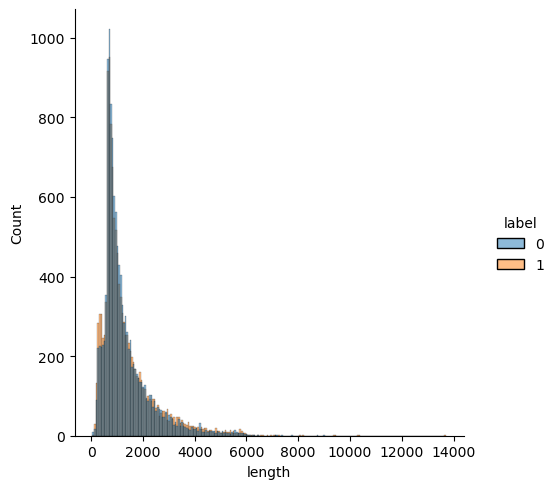

In [6]:
import seaborn as sns

sns.displot(train_df, x="length", hue="label")

The x-axis shows the unique `length` values in our data set, the y-axis is the number of times that length shows up, and the color is the label. The vast majority of reviews are under 2,000 characters. There are almost no reviews over 6,000 characters. There are two distinct peaks on the left side of the graph, let's zoom in on those.

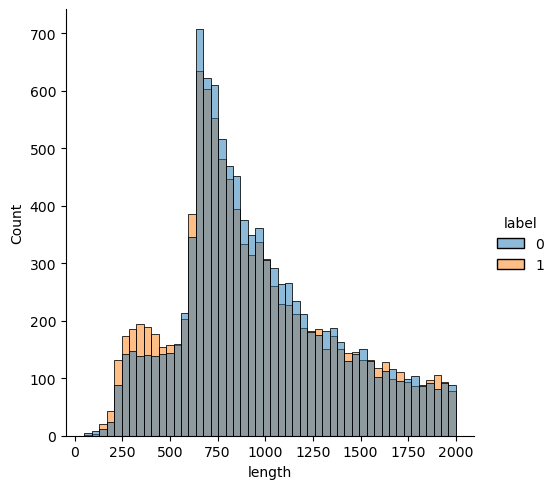

In [8]:
sns.displot(
    train_df[train_df["length"] < 2000], x="length", hue="label"
)

The first peak is between 250 and 500. We see a higher number of positive labels (orange) here, so if we made a prediction in this area it should probably be positive. The next peak is around 750. There is a higher number of negative labels (blue), so a negative prediction is called for here. The difference between negative and positive labels is slight though, so it's hard to expect our predictions to be accurate. That shouldn't stop us from trying though!

Let's scikit-learnify our model and see how it does on the `length` feature.

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels


class OneR(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        """Train on the categories in the first column of `X`."""
        # Convert to `numpy` arrays for consistency.
        X, y = np.array(X), np.array(y)

        # Store the classes.
        # sklearn provides a handy function `unique_labels` for this
        # purpose. You could also use `np.unique`.
        self.classes_ = unique_labels(y)

        predictors = {}
        # Get the unique categories from the first column.
        categories = np.unique(X[:, 0])
        for value in categories:
            # Create a boolean array where `True` indices indicate the
            # rows where value is `value`.
            is_value = X[:, 0] == value

            # Grab all data points and labels in this value.
            _X = X[is_value]
            _y = y[is_value]

            # Train a baseline classifier on the value.
            predictors[value] = DummyClassifier().fit(_X, _y)

        self.predictors_ = predictors

        # Create a fallback predictor for unknown categories.
        self.unknown_predictor_ = DummyClassifier().fit(X, y)
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        X = np.array(X)

        # Create an empty array that will hold the predictions.
        rv = np.zeros(X.shape[0])

        # Get the unique categories from the first column.
        categories = np.unique(X[:, 0])
        for value in categories:
            # Create a boolean array where `True` indices indicate the
            # rows where value is `value`.
            is_value = X[:, 0] == value

            # Grab all data points in this value.
            _X = X[is_value]

            # Predict the label for all datapoints in `_X`.
            try:
                predictions = self.predictors_[value].predict(_X)
            except KeyError:
                # Fallback to the predictor for unknown categories.
                predictions = self.unknown_predictor_.predict(_X)

            # Assign the prediction for this value to
            # the corresponding indices in `rv`.
            rv[is_value] = predictions
        return rv

Now we train and pray.

In [10]:
# Prepare the data for training again, focusing on the new feature.
features = ["length"]
X = train_df[features]
test_df["length"] = test_df["review"].str.len()
X_test = test_df[features]

# Train the model.
oner = OneR().fit(X, y)
oner.score(X_test, y_test)

0.5026653102746694

And the accuracy is still 50%. Bummer. Either our model isn't good enough or our feature extraction doesn't capture enough information from the reviews. In theory, our model will perform better if the feature is more informative, so next chapter we will look at improving our model by changing the features it's trained on.

## Multiclass classification

I don't expect this to work well, but let's see anyway.

In [13]:
# | echo: false
from nlpbook import get_multiclass_results

get_multiclass_results(["Baseline"])

,Accuracy
Model,
Baseline,0.199715


The baseline accuracy is 20%, can we do better?

In [14]:
oner = OneR().fit(X, train_df["rating"])
oner.score(X_test, test_df["rating"])

0.17367243133265514

Nope, but that's OK. It will get better in the future, I promise!